In [1]:
# !pip install plotly
import pandas as pd
!pip install pandas_ta
import pandas_ta as ta
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# import chart_studio.tools as tls

In [4]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



07-20-2017


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-07-20,223.461348,7.317111e+08,223.461348,NaN,NaN,NaN,NaN,NaN
2017-07-21,217.086474,3.903940e+08,218.503113,-6.374874,NaN,NaN,NaN,NaN
2017-07-22,231.143529,2.299701e+08,227.747596,14.057055,NaN,NaN,NaN,NaN
2017-07-23,226.718599,2.044678e+08,227.007668,-4.424930,NaN,NaN,NaN,NaN
2017-07-24,224.913407,1.442842e+08,225.508914,-1.805192,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-18,1477.255325,2.225492e+10,1466.236965,0.000000,65.508141,32.194192,51.155796,-18.961604
2022-07-18,1344.720284,1.579765e+10,1379.439336,-132.535041,54.509788,33.111674,41.658622,-8.546948
2022-07-18,1344.720284,2.225492e+10,1354.640013,0.000000,54.509788,33.453158,33.600085,-0.146927


In [5]:
mydf = mydf.dropna()

In [6]:
import statsmodels.api
import statsmodels as sm



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']
for i in myCols:
    res = sm.tsa.seasonal.seasonal_decompose(mydf[i],model='additive')
    fig = res.plot()
    fig.set_size_inches((16, 9))
    fig.tight_layout() 
    plt.show()

ValueError: ignored

In [8]:
my_data = mydf[myCols]
display(my_data)
my_data.corr()

,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
date,,,,,,
2017-08-22,312.174471,8.983443e+08,312.869997,65.012352,19.799499,-10.026750
2017-08-23,316.788920,4.664746e+08,315.669228,66.393109,19.856092,4.614450
2017-08-24,321.785298,3.977527e+08,320.037850,67.873967,20.072723,4.996378
2017-08-25,329.025281,4.519507e+08,326.457443,69.939510,20.591247,7.239983
2017-08-26,329.865783,3.338393e+08,328.891971,70.179075,20.829889,0.840502
...,...,...,...,...,...,...
2022-07-18,1477.255325,2.225492e+10,1466.236965,65.508141,32.194192,0.000000
2022-07-18,1344.720284,1.579765e+10,1379.439336,54.509788,33.111674,-132.535041
2022-07-18,1344.720284,2.225492e+10,1354.640013,54.509788,33.453158,0.000000


,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
ethereum,1.000000,0.532773,0.999823,0.091231,0.185081,0.030941
ethereum_volume,0.532773,1.000000,0.533815,0.233814,0.278443,-0.040953
ethereum_ewm,0.999823,0.533815,1.000000,0.085459,0.182851,0.012915
ethereum_rsi,0.091231,0.233814,0.085459,1.000000,0.603867,0.234220
macd,0.185081,0.278443,0.182851,0.603867,1.000000,0.073114
ethereum_diff,0.030941,-0.040953,0.012915,0.234220,0.073114,1.000000


In [18]:
### XGboost 

In [19]:
import xgboost as xgb

In [50]:
from sklearn.metrics import mean_squared_error

In [125]:
X,y=my_data.iloc[:,1:],my_data.iloc[:,0]

,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
date,,,,,
2017-08-18,5.904704e+08,297.133944,67.442249,25.878908,-4.455708
2017-08-19,5.537022e+08,296.768334,67.574501,24.685977,0.507454
2017-08-20,3.428230e+08,295.627793,66.744372,23.354312,-1.450512
2017-08-21,1.743910e+09,314.608812,73.323330,24.201050,27.029643
2017-08-22,8.983443e+08,312.869997,67.951405,23.788798,-10.026750
...,...,...,...,...,...
2022-07-14,1.390975e+10,1087.095315,40.096839,-62.694926,0.000000
2022-07-14,1.793689e+10,1105.542078,43.071422,-58.696055,27.766291
2022-07-14,1.390975e+10,1110.812581,43.071422,-54.894135,0.000000


In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
scaler=StandardScaler()

In [94]:
scaled_X=scaler.fit_transform(X)

In [41]:
from sklearn.model_selection import train_test_split

In [96]:
X_train,X_test,y_train,y_test=train_test_split(scaled_X,y,test_size=0.3, random_state=123)

In [97]:

xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)

In [98]:
xg_reg.fit(X_train,y_train)

[15:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, n_estimators=10)

In [99]:
preds=xg_reg.predict(X_test)

In [100]:
rmse=np.sqrt(mean_squared_error(y_test,preds))

In [101]:
rmse

1007.2907010584736

In [54]:
## visualizing the boost trees

In [55]:
params={'objective':'reg:linear','colsample_bytree':0.3,'learning_rate':0.1,
        'max_depth':5,'alpha':10}

In [56]:
data_dmatrix=xgb.DMatrix(data=X,label=y)

In [57]:
xg_reg=xgb.train(params=params,dtrain=data_dmatrix,num_boost_round=10)

[15:04:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


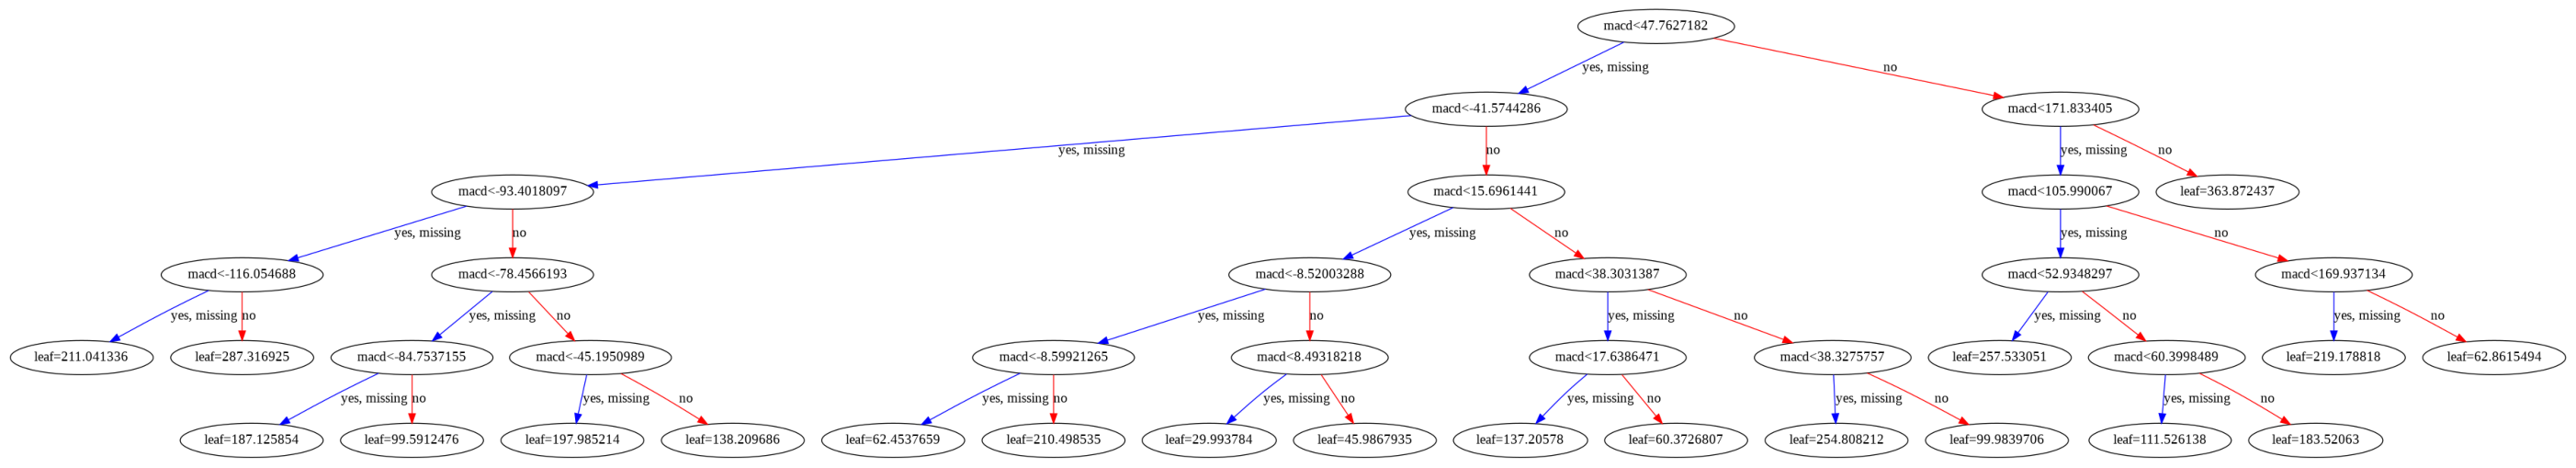

In [59]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize']=[5,10]
plt.show()

In [60]:
## feature importance 

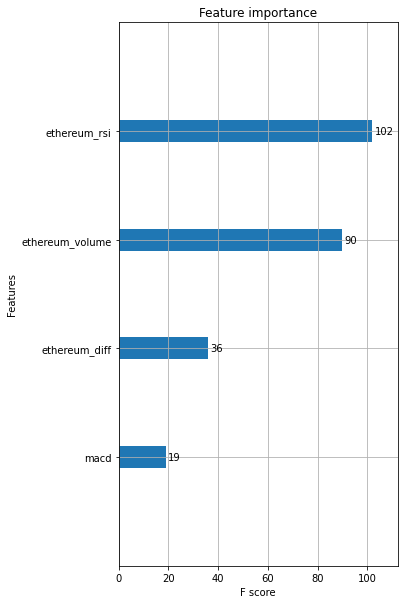

In [61]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize']=[5,5]
plt.show()

In [62]:
### validate the model 

In [126]:
shift_data=X.shift(periods=3,freq='D')

shift_data

,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
date,,,,,
2017-08-21,5.904704e+08,297.133944,67.442249,25.878908,-4.455708
2017-08-22,5.537022e+08,296.768334,67.574501,24.685977,0.507454
2017-08-23,3.428230e+08,295.627793,66.744372,23.354312,-1.450512
2017-08-24,1.743910e+09,314.608812,73.323330,24.201050,27.029643
2017-08-25,8.983443e+08,312.869997,67.951405,23.788798,-10.026750
...,...,...,...,...,...
2022-07-17,1.390975e+10,1087.095315,40.096839,-62.694926,0.000000
2022-07-17,1.793689e+10,1105.542078,43.071422,-58.696055,27.766291
2022-07-17,1.390975e+10,1110.812581,43.071422,-54.894135,0.000000


In [127]:
shift_data=shift_data[:-7]

In [128]:
X_new=shift_data.tail(3)

new_scaled_X=scaler.fit_transform(X_new)

X_new

,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
date,,,,,
2022-07-15,1.169316e+10,1122.106906,38.448602,-65.652390,-71.563270
2022-07-16,1.155580e+10,1064.028506,35.135851,-70.526609,-56.652293
2022-07-17,1.793689e+10,1098.951561,41.988562,-67.788266,72.123637


In [129]:
ypred=xg_reg.predict(new_scaled_X)
ypred

array([ 810.0552 ,  725.62024, 1134.9058 ], dtype=float32)

In [1]:
### Time series method 

In [9]:
### reset the index, convert the index to column 

In [15]:
new_data=my_data.reset_index(level=0)

In [16]:
new_data.tail(10)

,date,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
1789,2022-07-16,1234.099139,1.681719e+10,1214.297642,51.511001,-47.361288,42.968302
1790,2022-07-17,1355.045640,1.902583e+10,1314.831927,59.079833,-28.343586,120.946501
1791,2022-07-18,1344.720284,1.579765e+10,1336.180753,58.243628,-13.944348,-10.325356
1792,2022-07-18,1344.720284,2.225492e+10,1342.280418,58.243628,-2.503984,0.000000
1793,2022-07-18,1477.255325,1.579765e+10,1438.691066,65.508141,17.060395,132.535041
1794,2022-07-18,1477.255325,2.225492e+10,1466.236965,65.508141,32.194192,0.000000
1795,2022-07-18,1344.720284,1.579765e+10,1379.439336,54.509788,33.111674,-132.535041
1796,2022-07-18,1344.720284,2.225492e+10,1354.640013,54.509788,33.453158,0.000000
1797,2022-07-18,1477.255325,1.579765e+10,1442.222378,61.923830,43.912066,132.535041
1798,2022-07-18,1477.255325,2.225492e+10,1467.245911,61.923830,51.605945,0.000000


In [17]:
new_data=new_data[:-7]

In [18]:
new_data.tail(10)

,date,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
1782,2022-07-09,1233.514679,1.534660e+10,1229.959080,48.147752,-78.482918,-6.863726
1783,2022-07-10,1216.849707,7.870255e+09,1220.595242,46.845420,-68.799280,-16.664972
1784,2022-07-11,1169.012708,1.037447e+10,1183.750575,43.229436,-64.244404,-47.836999
1785,2022-07-12,1097.449438,1.169316e+10,1122.106906,38.448602,-65.652390,-71.563270
1786,2022-07-13,1040.797146,1.155580e+10,1064.028506,35.135851,-70.526609,-56.652293
1787,2022-07-14,1112.920783,1.793689e+10,1098.951561,41.988562,-67.788266,72.123637
1788,2022-07-15,1191.130837,1.647422e+10,1164.793901,48.359970,-58.631347,78.210054
1789,2022-07-16,1234.099139,1.681719e+10,1214.297642,51.511001,-47.361288,42.968302
1790,2022-07-17,1355.045640,1.902583e+10,1314.831927,59.079833,-28.343586,120.946501
1791,2022-07-18,1344.720284,1.579765e+10,1336.180753,58.243628,-13.944348,-10.325356


In [19]:
### autocorrelation 

In [20]:
autocorr_lag1=new_data['ethereum'].autocorr(lag=1)

In [21]:
print('One month lag: ', autocorr_lag1)

One month lag:  0.9979526957328209


In [25]:
autocorr_lag3=new_data['ethereum'].autocorr(lag=3)
print('One month lag: ', autocorr_lag3)

One month lag:  0.9942639413180313


In [26]:
autocorr_lag6=new_data['ethereum'].autocorr(lag=6)
print('One month lag: ', autocorr_lag6)

One month lag:  0.9883563717831565


In [27]:
autocorr_lag9=new_data['ethereum'].autocorr(lag=9)
print('One month lag: ', autocorr_lag9)

One month lag:  0.9817524481487904


In [35]:
### auto arima 

In [37]:
#!pip install pmdarima

In [38]:
from pmdarima.arima import auto_arima

In [42]:
X,y=new_data['date'],new_data['ethereum']

X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=123)

In [43]:
model=auto_arima(y_train, trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=21387.665, Time=2.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21382.683, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21384.143, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21384.116, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22077.910, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21386.217, Time=0.38 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.809 seconds


In [44]:
model.fit(y_train)

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [45]:
preds=model.predict(n_periods=len(y_test))

In [46]:
preds=pd.DataFrame(preds,index=y_test.index,columns=['Predictions'])

In [51]:
rmse=np.sqrt(mean_squared_error(y_test,preds['Predictions']))

In [52]:
rmse

1238.8017933672568

In [91]:
### test if time series stationary 

In [92]:
from statsmodels.tsa.stattools import adfuller

In [104]:
def test_stationarity(timeseries):
  rollmean=timeseries.rolling(12).mean()
  rollstd=timeseries.rolling(12).std()

  plt.plot(timeseries, color='blue', label='Original')
  plt.plot(rollmean, color='red', label='rolling mean')
  plt.plot(rollstd, color='black', label='rolling std')

  plt.legend(loc='best')
  plt.title('Rolling mean and standard deviation')
  plt.show()

  print('Results for Dickey Fuller test')

  test=adfuller(timeseries, autolag='AIC')
  output=pd.Series(test[0:4], index=['Test statistic', 'p-value',
                                     'lag_used', 'number_observations'])
  for key, value in test[4].items():
    output['Critical value (%s)'%key]=value 
    print(output)



In [105]:
ts_data=my_data.iloc[:,0][:-7]

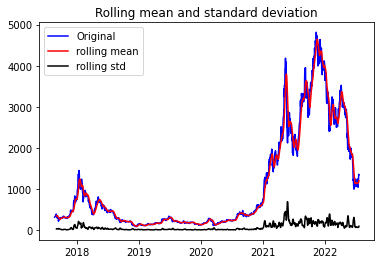

Results for Dickey Fuller test
Test statistic           -1.364296
p-value                   0.599268
lag_used                 17.000000
number_observations    1774.000000
Critical value (1%)      -3.434042
dtype: float64
Test statistic           -1.364296
p-value                   0.599268
lag_used                 17.000000
number_observations    1774.000000
Critical value (1%)      -3.434042
Critical value (5%)      -2.863171
dtype: float64
Test statistic            -1.364296
p-value                    0.599268
lag_used                  17.000000
number_observations     1774.000000
Critical value (1%)       -3.434042
Critical value (5%)       -2.863171
Critical value (10%)      -2.567638
dtype: float64


In [106]:
test_stationarity(ts_data)

In [ ]:
## thus this is not stationary because mean is increasing even though std is small; test statistic is greater than the critical value 

In [107]:
### make time series stationary 

In [108]:
ts_log=np.log(ts_data)

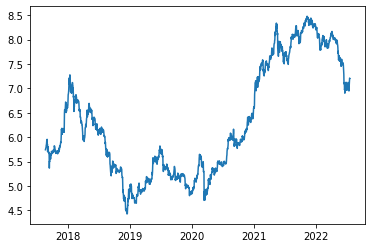

In [109]:
plt.plot(ts_log)

In [110]:
moving_avg=ts_log.rolling(12).mean()

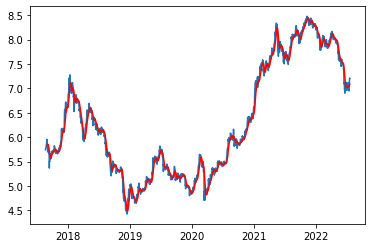

In [111]:
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [112]:
ts_moving_diff=ts_log - moving_avg

In [115]:
ts_moving_diff.dropna(inplace=True)

In [117]:
ts_moving_diff.head(5)

date
2017-09-02    0.002193
2017-09-03    0.002820
2017-09-04   -0.147455
2017-09-05   -0.084458
2017-09-06   -0.041854
Name: ethereum, dtype: float64

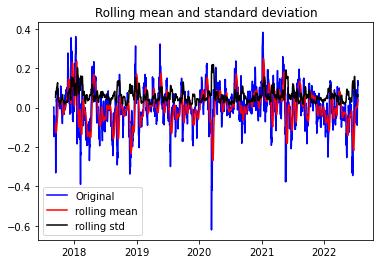

Results for Dickey Fuller test
Test statistic        -8.495896e+00
p-value                1.276223e-13
lag_used               1.100000e+01
number_observations    1.769000e+03
Critical value (1%)   -3.434052e+00
dtype: float64
Test statistic        -8.495896e+00
p-value                1.276223e-13
lag_used               1.100000e+01
number_observations    1.769000e+03
Critical value (1%)   -3.434052e+00
Critical value (5%)   -2.863175e+00
dtype: float64
Test statistic         -8.495896e+00
p-value                 1.276223e-13
lag_used                1.100000e+01
number_observations     1.769000e+03
Critical value (1%)    -3.434052e+00
Critical value (5%)    -2.863175e+00
Critical value (10%)   -2.567641e+00
dtype: float64


In [118]:
test_stationarity(ts_moving_diff)

In [ ]:
### now this series is stationary because the test staistics is smaller than the 5% critical value

In [119]:
### Seasonality 

In [121]:
ts_log=pd.DataFrame(ts_log)

In [135]:
ts_log_diff=ts_log - ts_log.shift()

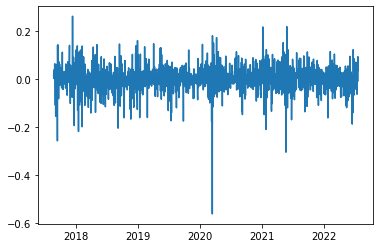

In [136]:
plt.plot(ts_log_diff)

In [137]:
ts_log_diff.dropna(inplace=True)

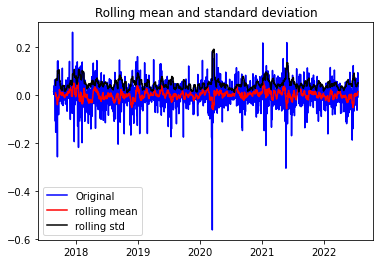

Results for Dickey Fuller test


ValueError: ignored

In [138]:
test_stationarity(ts_log_diff)

In [139]:
### decomposing 

In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [141]:
decompositions=seasonal_decompose(ts_log)

In [142]:
trend=decompositions.trend

In [143]:
seasonal=decompositions.seasonal

In [144]:
residuals=decompositions.resid

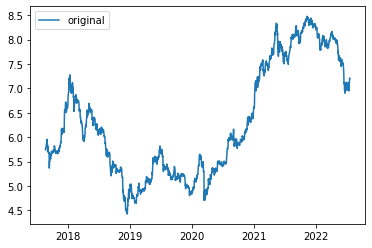

In [145]:
plt.plot(ts_log, label='original')
plt.legend(loc='best')

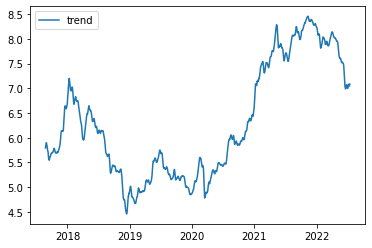

In [147]:
plt.plot(trend, label='trend')
plt.legend(loc='best')

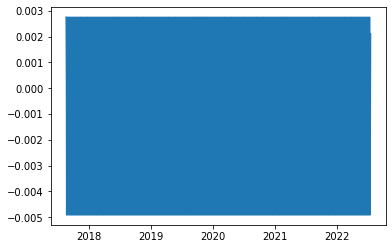

In [150]:
plt.plot(seasonal, label='seasonality')

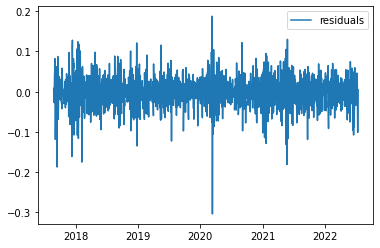

In [151]:
plt.plot(residuals, label='residuals')
plt.legend(loc='best')

In [152]:
#### use residuals to check stationarity

In [153]:
ts_log_decompose=residuals

In [154]:
ts_log_decompose.dropna(inplace=True)

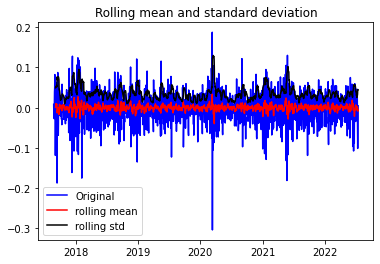

Results for Dickey Fuller test


ValueError: ignored

In [155]:
test_stationarity(ts_log_decompose)

In [156]:
### this is stationary 

In [157]:
## Forecast a time series 

In [158]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [159]:
lag_acf=acf(ts_log_diff, nlags=20)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  Returns


In [160]:
lag_pacf=pacf(ts_log_diff, nlags=20, method='ols')

In [161]:
## plot autocorrelation function

Text(0.5, 1.0, 'Autocorrelation Function')

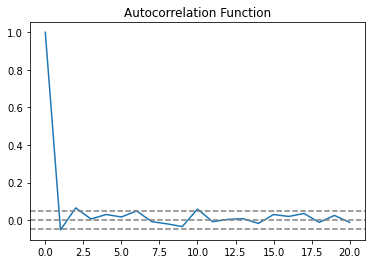

In [163]:
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='grey')
plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

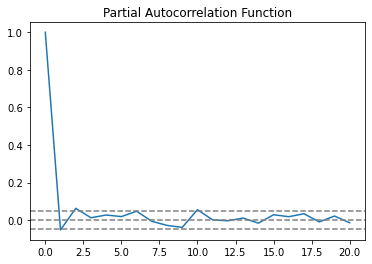

In [164]:
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='grey')
plt.title('Partial Autocorrelation Function')

In [53]:
### AR model 

In [165]:
model2=ARIMA(ts_log,order=(2,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,


In [166]:
results_AR=model2.fit(disp=-1)

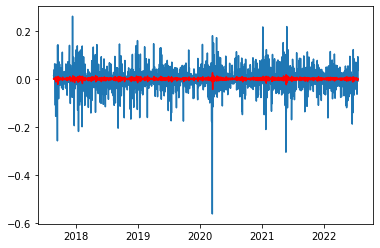

In [173]:
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')

In [207]:
mse=sum((results_AR.fittedvalues.values - ts_log_diff.values)**2).mean()

In [208]:
mse

4.934056371900995

In [81]:
### MA model

In [256]:
model3=ARIMA(ts_log_diff, order=(2,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,


In [257]:
results_MA=model3.fit(disp=-1)

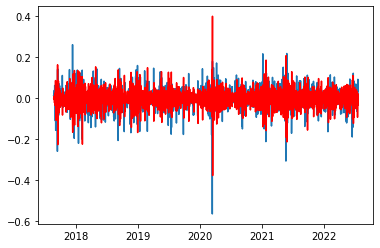

In [258]:
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')

In [209]:
mse=sum((results_MA.fittedvalues.values - ts_log_diff.values)**2).mean()
mse

8.845763653914927

In [86]:
### ARIMA model 

In [210]:
model4=ARIMA(ts_log, order=(2,1,2))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,


In [211]:
results_ARIMA=model4.fit(disp=-1)

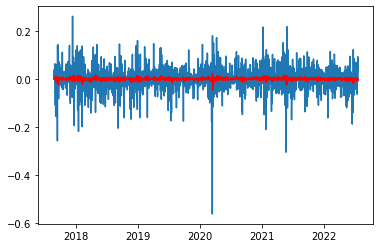

In [212]:
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [213]:
mse=sum((results_ARIMA.fittedvalues.values - ts_log_diff.values)**2).mean()
mse

4.9421665227365885

In [215]:
## auto correlation: find the best ARIMA model

In [214]:
model=auto_arima(ts_log, trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5488.086, Time=5.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5481.976, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5484.886, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5484.328, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5483.541, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5487.964, Time=1.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5488.415, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5488.028, Time=2.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5489.866, Time=0.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5488.142, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5486.171, Time=2.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5491.436, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5486.403, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5489.721, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0

In [216]:
optimal_model=ARIMA(ts_log, order=(2,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,


In [217]:
res_optimal_ARIMA=optimal_model.fit(disp=-1)

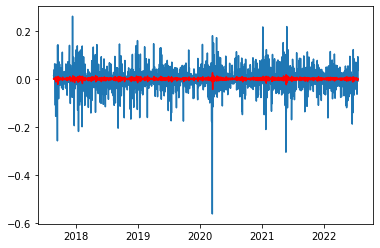

In [218]:
plt.plot(ts_log_diff)
plt.plot(res_optimal_ARIMA.fittedvalues, color='red')

In [221]:
mse=sum((res_optimal_ARIMA.fittedvalues.values - ts_log_diff.values)**2).mean()
mse

4.934056371900995

In [222]:
### final step: bring this back to original scale

In [226]:
preds_ARIMA_diff=pd.Series(res_optimal_ARIMA.fittedvalues, copy=True)

In [227]:
preds_ARIMA_diff_cumsum=preds_ARIMA_diff.cumsum()

In [248]:
preds_ARIMA_log=pd.Series(ts_log.iloc[0], index=ts_log.index)
preds_ARIMA_log=preds_ARIMA_log.add(preds_ARIMA_diff_cumsum, fill_value=0)


In [259]:
preds_ARIMA=np.exp(preds_ARIMA_log)
preds_ARIMA.fillna(0, inplace=True)
preds_ARIMA

date
2017-08-22    0.000000
2017-08-23    1.000820
2017-08-24    1.000914
2017-08-25    1.001872
2017-08-26    1.002566
                ...   
2022-07-14    4.322461
2022-07-15    4.297528
2022-07-16    4.304655
2022-07-17    4.318915
2022-07-18    4.312154
Length: 1792, dtype: float64

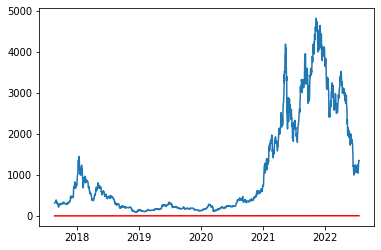

In [251]:
plt.plot(ts_data)
plt.plot(preds_ARIMA, color='red')

In [252]:
rmse=np.sqrt(sum((preds_ARIMA.values - ts_data.values)**2/len(ts_data)))
rmse

1621.5058688636952